In [8]:
import os
import numpy as np
import glob
import pandas as pd  
#from keras import utils as np_utils
import random
import math as mp
from scipy.signal import resample

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, models

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.models import load_model

#cnn.save('BONN_CNN_MODELtf2_v3.h5')  # creates a HDF5 file 'my_model.h5'


# returns a compiled model
# identical to the previous one
cnn = load_model('BONN_CNN_MODEL.h5')

W0622 14:44:30.603067 140108611426048 deprecation.py:323] From /home/ad930/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [3]:
# load generator
#from tensorflow.keras.models import load_model
gen = load_model('./GAN_Generator_model2.h5')

W0622 14:44:34.794040 140108611426048 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


In [4]:
# generate 100 synthetic seizure signals
signal_gen = []
for i in range(0,100):
    noise = tf.random.normal([1, 100])
    generated_signal = gen(noise, training=False)
    generated_signal = generated_signal[:,:,0,:]
    signal_gen.append(generated_signal[0])


In [5]:
signal_gen = np.array(signal_gen)

In [9]:
path='/home/ad930/datasetsv4/'
dr='non_seizures'
nfilenames=[]
end='/*.csv'
nfilenames=glob.glob(path + dr + end)

def generate_chbmit_datasets(filenames):
    counter=0
    oldFS=256
    newFS=173.61
    flag=0
    arry=[]    
    for files in filenames:
        if counter==100:
            break
        df=pd.read_csv(files)
        if '\'F3-C3\'' in df:
            #df = df["'F3-C3'"]
            df = df[['\'F3-C3\'']]
            if df.shape[0] == 6041:
                newNumSamples = mp.ceil((df.shape[0] / oldFS) * newFS)
                flag=1
            if df.shape[0] == 6042:
                newNumSamples = mp.floor((df.shape[0] / oldFS) * newFS)
                flag=1
            if flag==1:
                newData = pd.DataFrame(resample(df, newNumSamples))
                arry.append(np.array(newData,dtype="float32"))
            counter=counter+1
    return np.array(arry) 

In [10]:
chb_signals_n=generate_chbmit_datasets(nfilenames)
chb_signals_n.shape

(100, 4097, 1)

In [12]:
scaler=StandardScaler()

In [13]:
# Normalise synthetic seizure signals
X = signal_gen
XC=X
X1=X.reshape(len(X)*4097,order='F')
X2=X1.reshape(4097,len(X))

X2=scaler.fit_transform(X2)    #normalize(X2,axis=1)

X3=np.reshape(X2,4097*len(X),order='F')
X4=X3.reshape(len(X),4097,1)
X=X4
signal_gen = X

In [14]:
# Normalise non-seizure signals
X = chb_signals_n
XC=X
X1=X.reshape(len(X)*4097,order='F')
X2=X1.reshape(4097,len(X))

X2=scaler.fit_transform(X2)    #normalize(X2,axis=1)

X3=np.reshape(X2,4097*len(X),order='F')
X4=X3.reshape(len(X),4097,1)
X=X4
chb_signals_n = X

In [16]:
x_test = np.append(signal_gen,chb_signals_n, axis=0)  # 1,0
x_test.shape

(200, 4097, 1)

In [17]:
x_test.shape

(200, 4097, 1)

In [18]:
y_zero = np.zeros((100,),dtype='int64')
y_ones = np.ones((100,),dtype='int64')
y_test = np.append(y_ones, y_zero, axis=0)
y_test.shape


(200,)

In [19]:
y_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [20]:
# evaluate the model
score = cnn.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0]*100)
print('Test accuracy:', score[1]*100)

Test loss: 68.08135175704922
Test accuracy: 80.0000011920929


In [21]:
y_pred2 = cnn.predict(x=x_test, verbose=1)

200/200 [==============================] - 0s 532us/sample


In [22]:
y_pred3 = np.argmax(y_pred2, axis=1)

In [23]:
y_pred3

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0])

In [24]:
accuracy = accuracy_score(y_test, y_pred3)
print(accuracy*100)

80.0


In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    # '.2f' if normalize else 
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

[[ 60  40]
 [  0 100]]


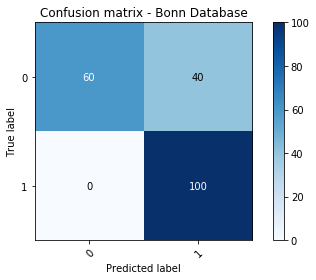

In [27]:
confusion_mat = plot_confusion_matrix(y_test, y_pred3, classes=[0,1], title='Confusion matrix - Bonn Database')

In [28]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred3,target_names = ['Non-Seizure(0)', 'Seizure(1)']))

                precision    recall  f1-score   support

Non-Seizure(0)       1.00      0.60      0.75       100
    Seizure(1)       0.71      1.00      0.83       100

      accuracy                           0.80       200
     macro avg       0.86      0.80      0.79       200
  weighted avg       0.86      0.80      0.79       200

